# Estimación y/o eliminación de la componente estacional del consumo de energía de PJM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression  # solo uso esta en la reg lineal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
import scipy as sp
import scipy.stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import numpy as np
import sklearn


Matplotlib is building the font cache; this may take a moment.


## Carga de los datos. 

In [3]:
import os
os.chdir("C:\\Users\\soffy\\OneDrive\\Escritorio\\Universidad\\Series_Tiempo")

In [62]:
# Cargar el archivo CSV
AEP_hourly = pd.read_csv("AEP_hourly.csv")

# Convertir la columna "Datetime" a objetos DateTime
AEP_hourly['Datetime'] = pd.to_datetime(AEP_hourly['Datetime'], format='%Y-%m-%d %H:%M:%S')

# Crear una nueva columna "fecha" con valores de fecha
AEP_hourly['fecha'] = AEP_hourly['Datetime'].dt.date




# Realizar la agregación por fecha y sumar la columna "AEP_MW"
energia = AEP_hourly.groupby('fecha')['AEP_MW'].sum().reset_index()

# Eliminar la fila 5055
energia = energia.drop(5054)

# Cambiar nombre de la variable
energia['Energia'] = energia['AEP_MW']
energia = energia.drop(columns='AEP_MW')

# Verificar los resultados
print(energia)

           fecha   Energia
0     2004-10-01  328544.0
1     2004-10-02  311997.0
2     2004-10-03  293450.0
3     2004-10-04  343417.0
4     2004-10-05  346553.0
...          ...       ...
5049  2018-07-29  327792.0
5050  2018-07-30  368834.0
5051  2018-07-31  364327.0
5052  2018-08-01  363628.0
5053  2018-08-02  376504.0

[5054 rows x 2 columns]


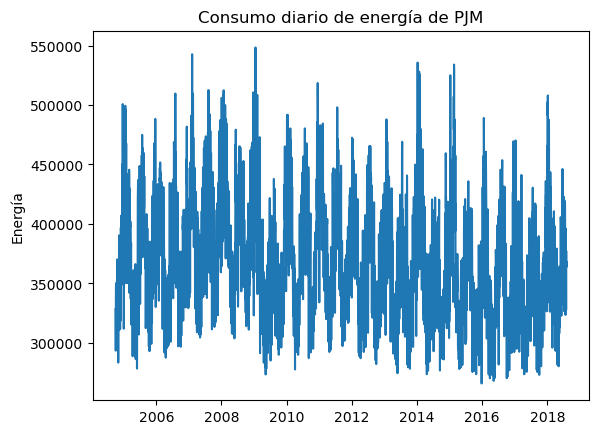

In [61]:
energia['fecha']=pd.to_datetime(energia['fecha']) # pasar a formato fecha
Valores_energia=energia.set_index('fecha') # nuevo dataframe indexado por la fecha
Valores_energia['Energia'] = pd.to_numeric(Valores_energia['Energia'], errors='coerce')
energia_ts=Valores_energia['Energia'] # vector con los valores de la serie

plt.plot(energia_ts)
plt.title('Consumo diario de energía de PJM')
plt.ylabel('Energía')
plt.show()

In [73]:
indice = pd.date_range(start='1/1/2004', periods=5054, freq='D')
indice
energiats =pd.Series(energia['Energia'].values,index=indice)
energiadf =pd.DataFrame(energia['Energia'].values,index=indice)

pandas.core.series.Series

Ahora procederemos a estimar el ciclo estacional que se observa en esta serie de tiempo, es importante resaltar que con ayuda de los graficos exploratorios y el periodograma se observo que el periodo de la componente estacional es $s=183$, por lo tanto utilizaremos en primer lugar componentes de fourier, esto teniendo en cuenta que se aprecia que la componente estacional sigue un comportamiento deterministico y posiblemente sinosoidal.
Teniendo lo anterior en cuenta el modelo viene dado por:
$$\begin{align*}
x_t&=  ∑_{i=1}^k a_icos(k𝜔t)+b_isen(k𝜔t) + w_t \\
\end{align*}$$
Donde $k$ corresponderá al orden de la expansión en series de Fourier y los coeficientes $a_i$ y $b_i$ con $i=1,...,k$ serán estimados a través del método de mínimos cuadrados. El cálculo de esta componente se muestra a continuación considerando un orden $k=3$. 

In [58]:
frec_ang=(2*np.pi/183) #w=2*pi/s
energia2=energia.copy()

#Fourier k=1 
energia2['Year sin'] = np.sin(np.arange(1,5055)*(1*frec_ang))
energia2['Year cos'] = np.cos(np.arange(1,5055)*(1*frec_ang))

# Fourier k=2 
energia2['Year sin2'] = np.sin(np.arange(1,5055)*(2*frec_ang))
energia2['Year cos2'] = np.cos(np.arange(1,5055)*(2*frec_ang))

# Fourier k=3
energia2['Year sin3'] = np.sin(np.arange(1,5055)*(3*frec_ang))
energia2['Year cos3'] = np.cos(np.arange(1,5055)*(3*frec_ang))

#plt.plot(np.array(energia2['Year sin'])[:13], color="red", label="k=1")
#plt.plot(np.array(energia2['Year cos'])[:13], color="red")

#plt.plot(np.array(energia2['Year sin2'])[:13], color="blue", label="k=2")
#plt.plot(np.array(energia2['Year cos2'])[:13], color="blue")

#plt.plot(np.array(energia2['Year sin3'])[:13], color="green", label="k=3")
#plt.plot(np.array(energia2['Year cos3'])[:13], color="green")

#plt.xlabel('Time [h]')
#plt.title('Time of year signal')
#plt.legend()

In [103]:
X=np.column_stack((energia2['Year cos'],energia2['Year sin'],energia2['Year cos2'],energia2['Year sin2'],energia2['Year cos3'],energia2['Year sin3']))
energiasola=energia2['Energia']
linmodel_ciclo = sm.OLS(energiasola, X)
results_ciclo = linmodel_ciclo.fit()
print(results_ciclo.summary())

                                 OLS Regression Results                                
Dep. Variable:                Energia   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              4.475
Date:                Fri, 06 Oct 2023   Prob (F-statistic):                    0.000159
Time:                        20:29:45   Log-Likelihood:                         -72023.
No. Observations:                5054   AIC:                                  1.441e+05
Df Residuals:                    5048   BIC:                                  1.441e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

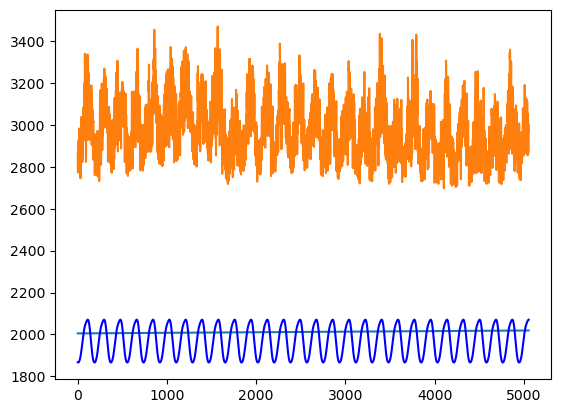

In [104]:
ypred = results_ciclo.predict(X)
energia2["predict estacion"] = ypred
plt.plot(energia)
plt.plot(energia2["predict estacion"], color="blue")
plt.show()


#plt.plot(energia2)
#plt.plot(results_ciclo.predict(X), color="blue")
#plt.show()

# Árboles de decisión

## Creación de variables rezagadas

In [105]:
from pandas import DataFrame

# reframe as supervised learning
# lag observation (t-1) is the input variable and t is the output variable.
df1 = DataFrame()
print(df1)

for i in range(3,0,-1):
    df1[['t-'+str(i)]] = energiadf.shift(i)
    
for i in range(185,182,-1):   
    df1[['t-'+str(i)]] = energiadf.shift(i)
print(df1)

Empty DataFrame
Columns: []
Index: []
                 t-3       t-2       t-1     t-185     t-184     t-183
2004-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2004-01-02       NaN       NaN  328544.0       NaN       NaN       NaN
2004-01-03       NaN  328544.0  311997.0       NaN       NaN       NaN
2004-01-04  328544.0  311997.0  293450.0       NaN       NaN       NaN
2004-01-05  311997.0  293450.0  343417.0       NaN       NaN       NaN
...              ...       ...       ...       ...       ...       ...
2017-10-28  395382.0  379599.0  338714.0  403360.0  390355.0  348457.0
2017-10-29  379599.0  338714.0  327792.0  390355.0  348457.0  326238.0
2017-10-30  338714.0  327792.0  368834.0  348457.0  326238.0  387501.0
2017-10-31  327792.0  368834.0  364327.0  326238.0  387501.0  431889.0
2017-11-01  368834.0  364327.0  363628.0  387501.0  431889.0  422231.0

[5054 rows x 6 columns]


In [106]:
# Create column t
df1['t'] = energiadf.values
print(df1.head(13))

                 t-3       t-2       t-1  t-185  t-184  t-183         t
2004-01-01       NaN       NaN       NaN    NaN    NaN    NaN  328544.0
2004-01-02       NaN       NaN  328544.0    NaN    NaN    NaN  311997.0
2004-01-03       NaN  328544.0  311997.0    NaN    NaN    NaN  293450.0
2004-01-04  328544.0  311997.0  293450.0    NaN    NaN    NaN  343417.0
2004-01-05  311997.0  293450.0  343417.0    NaN    NaN    NaN  346553.0
2004-01-06  293450.0  343417.0  346553.0    NaN    NaN    NaN  346195.0
2004-01-07  343417.0  346553.0  346195.0    NaN    NaN    NaN  346786.0
2004-01-08  346553.0  346195.0  346786.0    NaN    NaN    NaN  344408.0
2004-01-09  346195.0  346786.0  344408.0    NaN    NaN    NaN  310429.0
2004-01-10  346786.0  344408.0  310429.0    NaN    NaN    NaN  294249.0
2004-01-11  344408.0  310429.0  294249.0    NaN    NaN    NaN  343194.0
2004-01-12  310429.0  294249.0  343194.0    NaN    NaN    NaN  350758.0
2004-01-13  294249.0  343194.0  350758.0    NaN    NaN    NaN  3

In [107]:
# Create a new subsetted dataframe, removing Nans from first 185 rows
df1_energia = df1[185:]
print(df1_energia)
df1_energia.size

                 t-3       t-2       t-1     t-185     t-184     t-183  \
2004-07-04  348358.0  350010.0  315021.0  328544.0  311997.0  293450.0   
2004-07-05  350010.0  315021.0  352225.0  311997.0  293450.0  343417.0   
2004-07-06  315021.0  352225.0  346789.0  293450.0  343417.0  346553.0   
2004-07-07  352225.0  346789.0  337256.0  343417.0  346553.0  346195.0   
2004-07-08  346789.0  337256.0  339447.0  346553.0  346195.0  346786.0   
...              ...       ...       ...       ...       ...       ...   
2017-10-28  395382.0  379599.0  338714.0  403360.0  390355.0  348457.0   
2017-10-29  379599.0  338714.0  327792.0  390355.0  348457.0  326238.0   
2017-10-30  338714.0  327792.0  368834.0  348457.0  326238.0  387501.0   
2017-10-31  327792.0  368834.0  364327.0  326238.0  387501.0  431889.0   
2017-11-01  368834.0  364327.0  363628.0  387501.0  431889.0  422231.0   

                   t  
2004-07-04  352225.0  
2004-07-05  346789.0  
2004-07-06  337256.0  
2004-07-07  339447.

34083

## Partición de los datos

In [108]:
energiasplit = df1_energia.values
# split into lagged variables and original time series
X1= energiasplit[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y1 =energiasplit[:,-1]  # slice all rows and last column, essentially separating out 't' column

In [109]:
print(X1[0])
print(y1[0])

[348358. 350010. 315021. 328544. 311997. 293450.]
352225.0


In [110]:
Y1 = y1
print('Complete Observations for Target after Supervised configuration: %d' %len(Y1))
traintarget_size = int(len(Y1) * 0.70) 
valtarget_size = int(len(Y1) * 0.10)+1# Set split
testtarget_size = int(len(Y1) * 0.20)# Set split
print(traintarget_size,valtarget_size,testtarget_size)
print('Train + Validation + Test: %d' %(traintarget_size+valtarget_size+testtarget_size))

train_target, val_target,test_target = Y1[0:traintarget_size],Y1[(traintarget_size):(traintarget_size+valtarget_size)] ,Y1[(traintarget_size+valtarget_size):len(Y1)]

print('Observaciones respuesta: %d' % (len(Y1)))
print('Observaciones para entrenamiento: %d' % (len(train_target)))
print('Observaciones para validación: %d' % (len(val_target)))
print('Observaciones para prueba: %d' % (len(test_target)))

Complete Observations for Target after Supervised configuration: 4869
3408 487 973
Train + Validation + Test: 4868
Observaciones respuesta: 4869
Observaciones para entrenamiento: 3408
Observaciones para validación: 487
Observaciones para prueba: 974


In [111]:
trainfeature_size = int(len(X1) * 0.70)
valfeature_size = int(len(X1) * 0.10)+1# Set split
testfeature_size = int(len(X1) * 0.20)# Set split
train_feature, val_feature,test_feature = X1[0:traintarget_size],X1[(traintarget_size):(traintarget_size+valtarget_size)] ,X1[(traintarget_size+valtarget_size):len(Y1)]

print('Observations for Feature: %d' % (len(X1)))
print('Training Observations for Feature: %d' % (len(train_feature)))
print('Validation Observations for Feature: %d' % (len(val_feature)))
print('Test Observations for Feature: %d' % (len(test_feature)))

Observations for Feature: 4869
Training Observations for Feature: 3408
Validation Observations for Feature: 487
Test Observations for Feature: 974


## Modelo de regresión de árboles de decisión

In [112]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_energia = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_energia.fit(train_feature, train_target)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_energia.score(train_feature, train_target))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_energia.score(val_feature,val_target))  # predictions are horrible if negative value, no relationship if 0
print("el RECM es:",(((decision_tree_energia.predict(val_feature)-val_target)**2).mean())**0.5)

Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: 0.5494997681519316
el RECM es: 30968.59391764727


In [113]:
for d in [2, 3, 4, 5,6,7,8,9,10]:
    # Create the tree and fit it
    decision_tree_energia = DecisionTreeRegressor(max_depth=d)
    decision_tree_energia.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('\n max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_energia.score(train_feature, train_target))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_energia.score(val_feature, val_target), '\n')  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_energia.predict(val_feature),val_target, squared=False),'\n')


 max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.658360327587866
Coeficiente R2 sobre el conjunto de validación: 0.6239515985479158 

el RECM sobre el conjunto de validación es: 28294.097864138592 


 max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7035031774397923
Coeficiente R2 sobre el conjunto de validación: 0.6873576071014897 

el RECM sobre el conjunto de validación es: 25798.705261637126 


 max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7237167033407064
Coeficiente R2 sobre el conjunto de validación: 0.6633315776688471 

el RECM sobre el conjunto de validación es: 26771.651924392514 


 max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7535802734505326
Coeficiente R2 sobre el conjunto de validación: 0.6619543639778683 

el RECM sobre el conjunto de validación es: 26826.35360356726 


 max_depth= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7846018097351215
Coeficiente R2 sobre el conjunto de valid

### Juntamos entrenamiento y validación

In [114]:
print(type(train_feature))
print(type(val_feature))

#######

print(type(train_target))
print(type(val_target))

####
print(train_feature.shape)
print(val_feature.shape)

#####

####
print(train_target.shape)
print(val_target.shape)

###Concatenate Validation and test

train_val_feature=np.concatenate((train_feature,val_feature),axis=0)
train_val_target=np.concatenate((train_target,val_target),axis=0)
print(train_val_feature.shape)
print(train_val_target.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3408, 6)
(487, 6)
(3408,)
(487,)
(3895, 6)
(3895,)


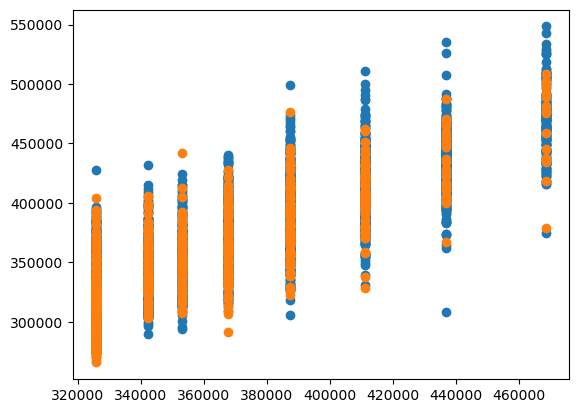

Raíz de la Pérdida cuadrática Entrenamiento: 25571.308762370234
Raíz de la Pérdida cuadrática Prueba: 25381.06651995408


In [115]:
# Prediccion utilizando los datos sumados de entrenamiento y validación y con la profundidad 3.

from matplotlib import pyplot as plt

# UUsando la mejor maxima profundidad

decision_tree_energia = DecisionTreeRegressor(max_depth=3)  # fill in best max depth here
decision_tree_energia.fit(train_val_feature, train_val_target)

# Prediciendo valores para entrenamiento y prueba 
train_val_prediction = decision_tree_energia.predict(train_val_feature)
test_prediction = decision_tree_energia.predict(test_feature)

# Comparación de los valores predichos vs los reales 
plt.scatter(train_val_prediction, train_val_target, label='train')  # blue
plt.scatter(test_prediction, test_target, label='test')  # orange
plt.show()
print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction, train_val_target,squared=False))

print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction, test_target,squared=False))

In [116]:
from sklearn import tree

listacaract=list(df1_energia.columns.values)
respuesta=listacaract.pop()
text_representation = tree.export_text(decision_tree_energia)
print(text_representation)

|--- feature_2 <= 375243.50
|   |--- feature_2 <= 348614.00
|   |   |--- feature_2 <= 334041.50
|   |   |   |--- value: [325652.29]
|   |   |--- feature_2 >  334041.50
|   |   |   |--- value: [342479.45]
|   |--- feature_2 >  348614.00
|   |   |--- feature_2 <= 358339.50
|   |   |   |--- value: [353213.76]
|   |   |--- feature_2 >  358339.50
|   |   |   |--- value: [367574.95]
|--- feature_2 >  375243.50
|   |--- feature_2 <= 433683.50
|   |   |--- feature_2 <= 402552.00
|   |   |   |--- value: [387513.71]
|   |   |--- feature_2 >  402552.00
|   |   |   |--- value: [411296.86]
|   |--- feature_2 >  433683.50
|   |   |--- feature_2 <= 463447.00
|   |   |   |--- value: [436988.37]
|   |   |--- feature_2 >  463447.00
|   |   |   |--- value: [468863.70]



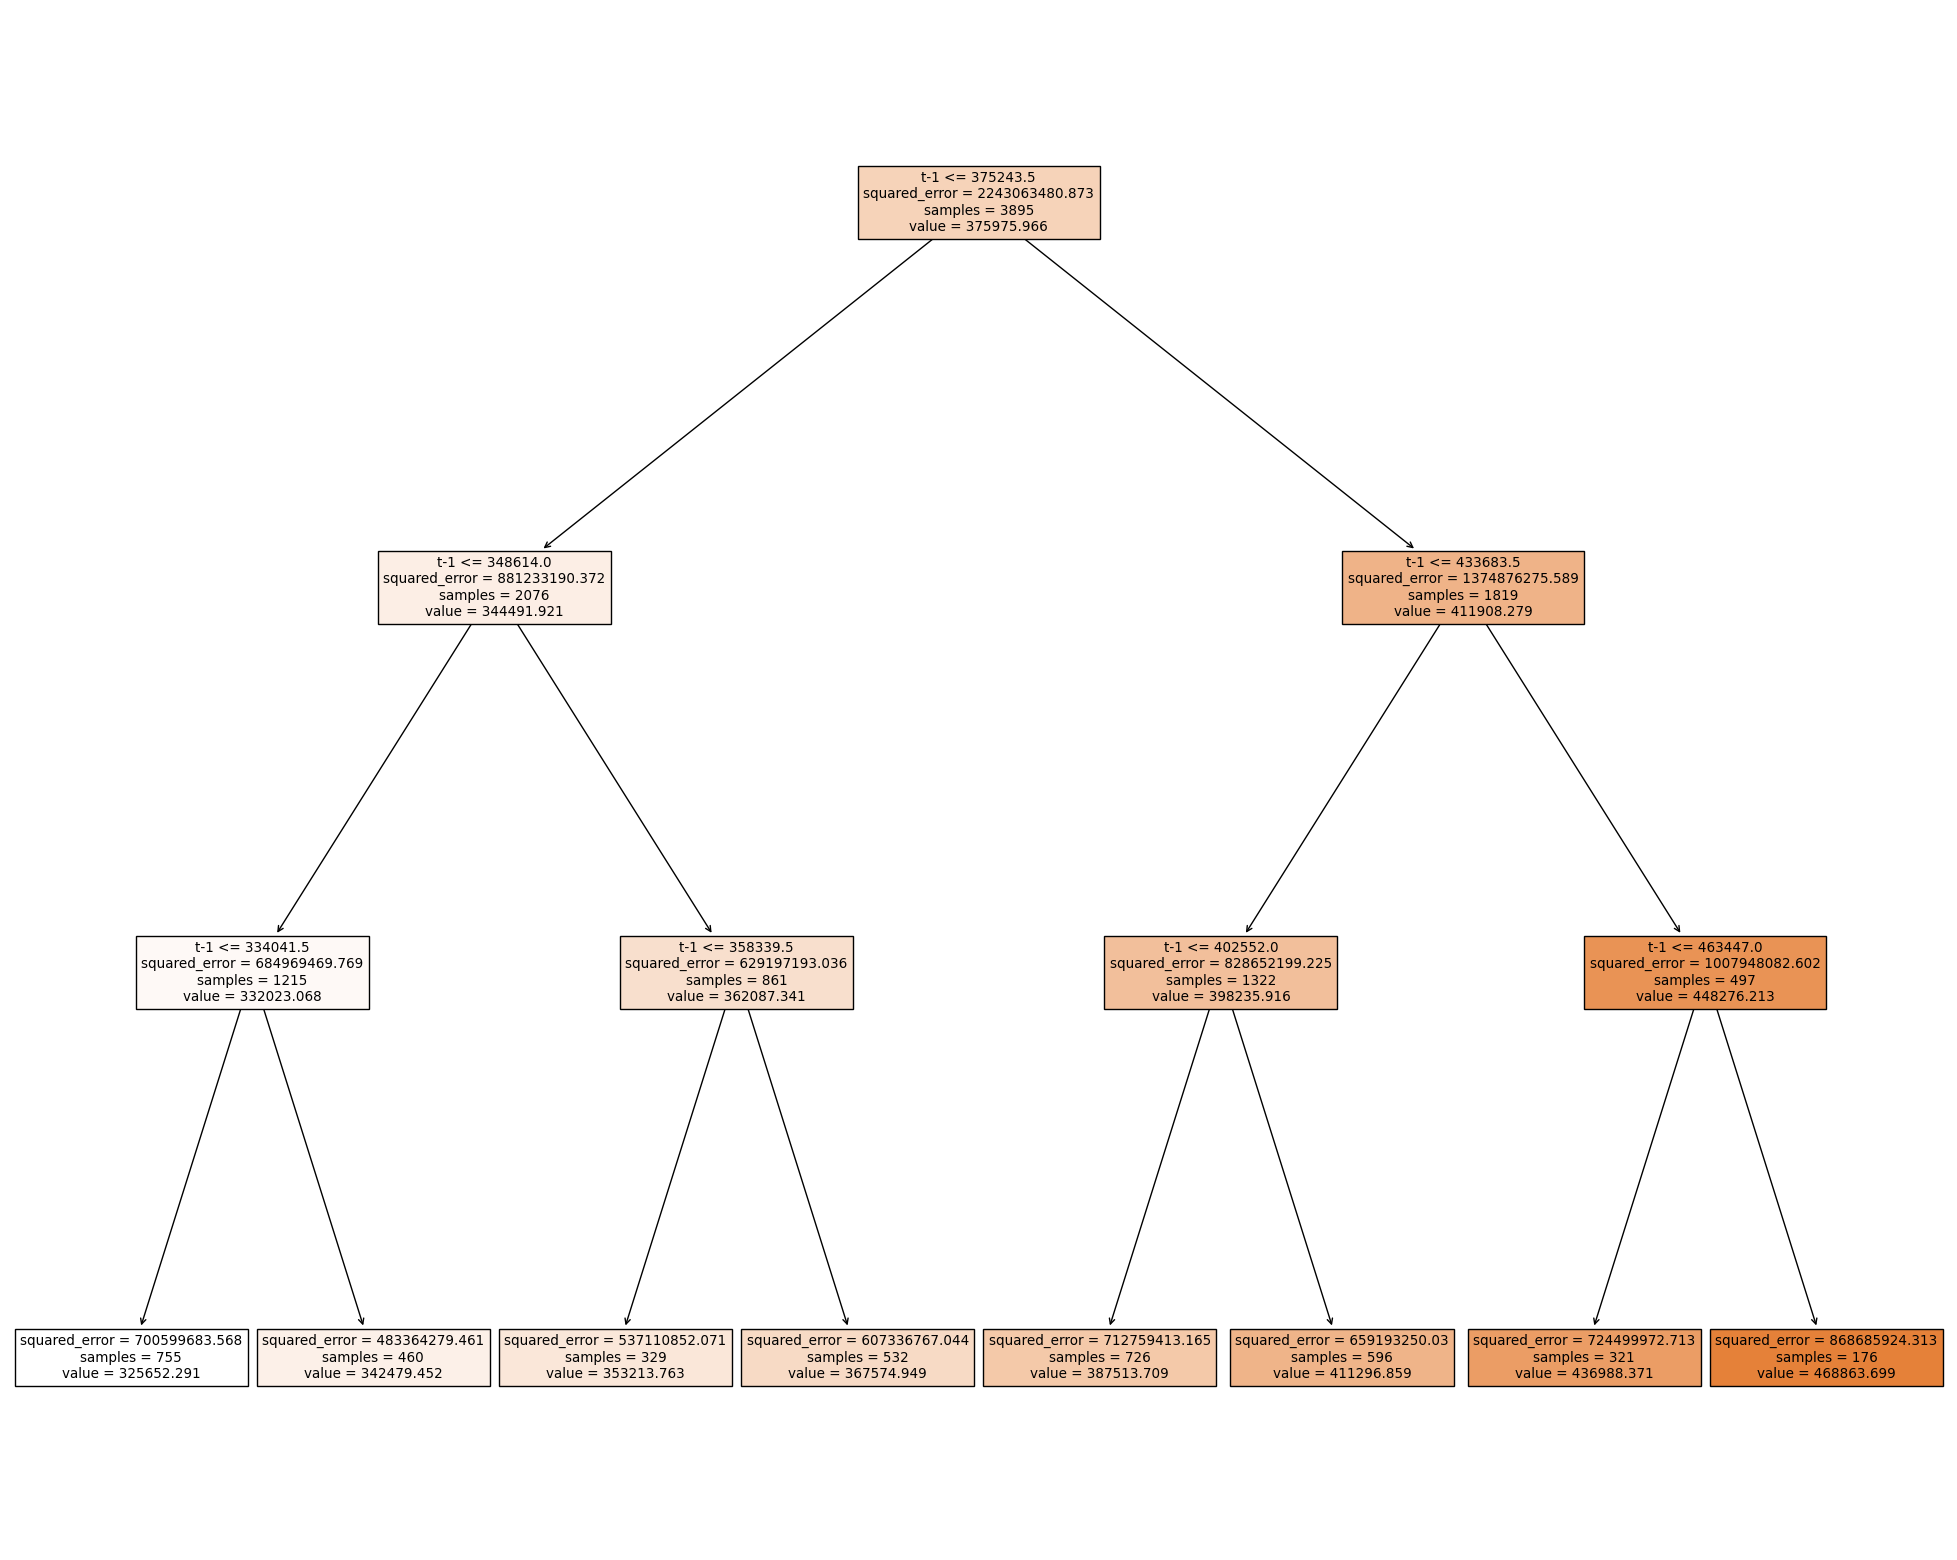

In [117]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_energia, 
                   feature_names=listacaract,  
                   class_names=respuesta,
                   filled=True)

In [118]:
print(train_val_prediction.size)
print(train_val_target.size)

print(test_prediction.size)
print(test_target.size)

3895
3895
974
974


In [119]:
indicetrian_val_test=df1_energia.index
print(indicetrian_val_test.size)  ###Tamaño del índice
indicetrain_val=indicetrian_val_test[0:3749]
indicetest=indicetrian_val_test[3749:4686]

4869


In [120]:
targetjoint=np.concatenate((train_val_target,test_target))
predictionjoint=np.concatenate((train_val_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

4869
4869


In [121]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_val_test)
ObsvsPred.head(10)

,observado,Predicción
2004-07-04,352225.0,325652.291391
2004-07-05,346789.0,353213.762918
2004-07-06,337256.0,342479.452174
2004-07-07,339447.0,342479.452174
2004-07-08,335421.0,342479.452174
2004-07-09,303655.0,342479.452174
2004-07-10,288786.0,325652.291391
2004-07-11,329595.0,325652.291391
2004-07-12,335568.0,325652.291391
2004-07-13,346691.0,342479.452174


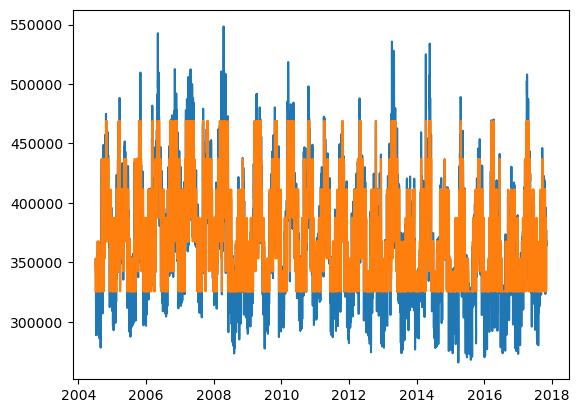

In [122]:
plt.plot(ObsvsPred)

# Redes neuronales